# spacetrackのテスト その2

ダウンロードしたデータをいろいろプロットしてみる

In [1]:
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from datetime import datetime
import numpy as np
import pandas as pd
import os
import time
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# userid and password are set in here
import spacetrackaccount
# print("Login with " + spacetrackaccount.userid)

In [4]:
st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)

In [5]:
def mycallback(until):
    duration = int(round(until - time.monotonic()))
    print('Sleeping for {:d} seconds.'.format(duration))

st.callback = mycallback

In [6]:
# 全衛星の最新データ(30日以内)をJSONで取得 (既にダウンロード済みの場合はそれを使う)
file = 'download/tle_latest_30day.json'
if not os.path.isfile(file):
    print('Downloading new data')
    data = st.tle_latest(ordinal=1, epoch='>now-30', orderby='norad_cat_id', format='json')
    with open(file, 'w') as fp:
        fp.write(data)
    df = pd.read_json(data)
else:
    print('Using pre-existing data')
    df = pd.read_json(file)

Using pre-existing data


In [7]:
df.head(3)

,ORDINAL,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED
0,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,5,VANGUARD 1,PAYLOAD,U,58002B,2020-11-02 21:53:16,247904,10.848688,0.184711,34.2559,161.7239,255.4599,83.4935,0,999,22029,-0.000021,3.000000e-08,0.0,2869318,0 VANGUARD 1,1 5U 58002B 20307.91199361 +.00000003 +00000-0 -20521-4 0 9999,2 5 034.2559 161.7239 1847114 255.4599 083.4935 10.84868846220299,1958-002B,5.0,8619.531,132.734,3833.522,649.271,0.0
1,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,11,VANGUARD 2,PAYLOAD,U,59001A,2020-11-02 21:13:36,661440,11.856847,0.146670,32.8743,255.6630,312.9380,35.6929,0,999,29141,0.000105,2.180000e-06,0.0,2869318,0 VANGUARD 2,1 11U 59001A 20307.88445210 +.00000218 +00000-0 +10470-3 0 9997,2 11 032.8743 255.6630 1466698 312.9380 035.6929 11.85684689291411,1959-001A,11.0,8123.734,121.448,2937.105,554.092,0.0
2,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,12,VANGUARD R/B,ROCKET BODY,U,59001B,2020-11-02 19:43:57,48384,11.443467,0.166637,32.8976,226.8616,83.4083,295.2617,0,999,29583,0.000222,3.650000e-06,0.0,2869318,0 VANGUARD R/B,1 12U 59001B 20307.82218806 +.00000365 +00000-0 +22198-3 0 9994,2 12 032.8976 226.8616 1666373 083.4083 295.2617 11.44346712295831,1959-001B,12.0,8318.214,125.835,3326.203,553.954,0.0


In [8]:
# OBJECT_NUMBER と DECAYED が float64 となっている (欠損値NaNを含むため)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20010 entries, 0 to 20009
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ORDINAL              20010 non-null  int64  
 1   COMMENT              20010 non-null  object 
 2   ORIGINATOR           20010 non-null  object 
 3   NORAD_CAT_ID         20010 non-null  int64  
 4   OBJECT_NAME          20010 non-null  object 
 5   OBJECT_TYPE          20010 non-null  object 
 6   CLASSIFICATION_TYPE  20010 non-null  object 
 7   INTLDES              19536 non-null  object 
 8   EPOCH                20010 non-null  object 
 9   EPOCH_MICROSECONDS   20010 non-null  int64  
 10  MEAN_MOTION          20010 non-null  float64
 11  ECCENTRICITY         20010 non-null  float64
 12  INCLINATION          20010 non-null  float64
 13  RA_OF_ASC_NODE       20010 non-null  float64
 14  ARG_OF_PERICENTER    20010 non-null  float64
 15  MEAN_ANOMALY         20010 non-null 

In [9]:
# OBJECT_TYPE は 4種類の値を取る
df.query('OBJECT_TYPE != "PAYLOAD" and OBJECT_TYPE != "ROCKET BODY" and OBJECT_TYPE != "DEBRIS" and OBJECT_TYPE != "TBA"')

,ORDINAL,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED


In [10]:
# TLE文字列も含まれている
df[['TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2']][0:1]

,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,0 VANGUARD 1,1 5U 58002B 20307.91199361 +.00000003 +00000-0 -20521-4 0 9999,2 5 034.2559 161.7239 1847114 255.4599 083.4935 10.84868846220299


In [11]:
# 衛星の位置・速度を計算する
sat = twoline2rv(df['TLE_LINE1'][0], df['TLE_LINE2'][0], wgs84)
ut = datetime.utcnow()
print(ut)
sat_position, sat_velocity = sat.propagate(ut.year, ut.month, ut.day, ut.hour, ut.minute, ut.second)
sat_position, sat_velocity

2020-11-03 07:55:49.899030


((6303.819920461137, -5591.5351431174195, 2149.4400703916785),
 (3.491872049391599, 4.45780534966924, -3.658404153042091))

In [12]:
# 3次元プロットするために、現在時刻の座標を求める
x = []
y = []
z = []
c = []
colors = {'PAYLOAD': 'green', 'ROCKET BODY': 'blue', 'DEBRIS': 'red', 'TBA' : 'black'}
ut = datetime.utcnow()
print(ut)
for line1, line2, object_type in zip(df['TLE_LINE1'], df['TLE_LINE2'], df['OBJECT_TYPE']):
    sat = twoline2rv(line1, line2, wgs84)
    sat_position, sat_velocity = sat.propagate(ut.year, ut.month, ut.day, ut.hour, ut.minute, ut.second)
    x.append(sat_position[0])
    y.append(sat_position[1])
    z.append(sat_position[2])
    c.append(colors[object_type])

2020-11-03 07:55:49.905351


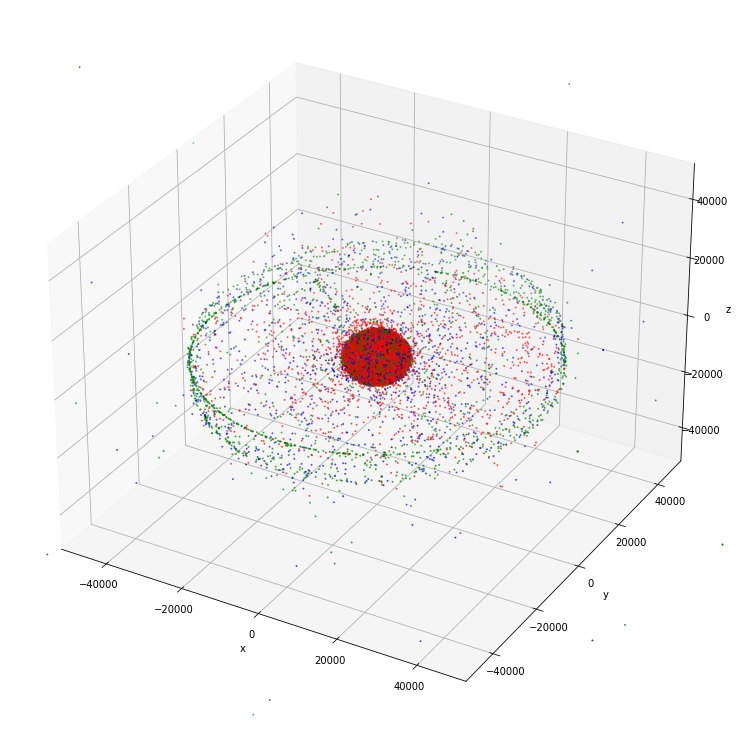

In [13]:
#%matplotlib notebook
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)
ax.set_zlim(-50000, 50000)
ax.scatter3D(x, y, z, c = c, marker = "o", s = 1)
plt.show()

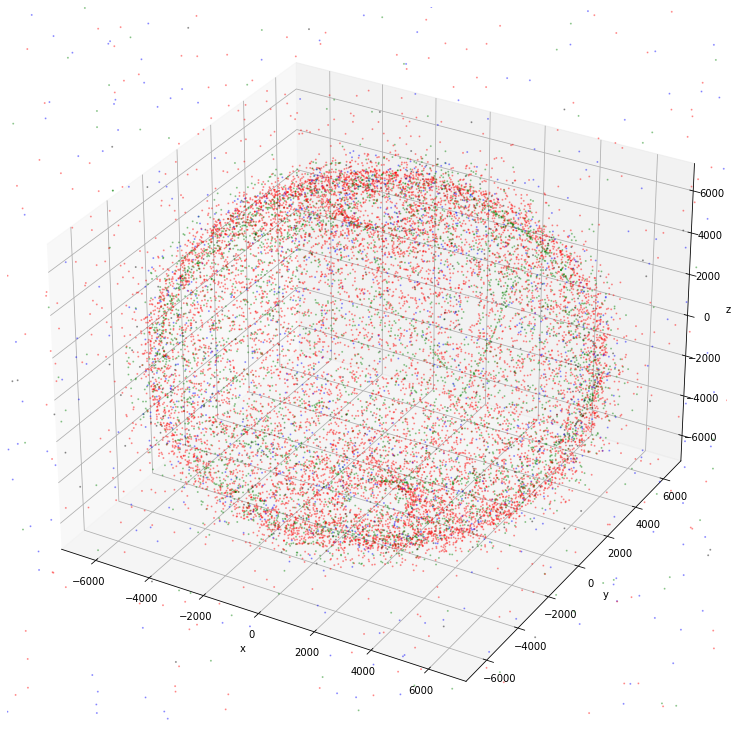

In [14]:
#%matplotlib notebook
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-7000, 7000)
ax.set_ylim(-7000, 7000)
ax.set_zlim(-7000, 7000)
ax.scatter3D(x, y, z, c = c, marker = "o", s = 1)
plt.show()

In [15]:
# ISSの過去の全データをJSONで取得 (既にダウンロード済みの場合はそれを使う)
norad_cat_id = 25544
file = 'download/tle_{}_all.json'.format(norad_cat_id)
if not os.path.isfile(file):
    print('Downloading new data')
    data2 = st.tle(norad_cat_id=norad_cat_id, orderby='epoch', format='json')
    with open(file, 'w') as fp:
        fp.write(data2)
    d2 = pd.read_json(data2)
else:
    print('Using pre-existing data')
    df2 = pd.read_json(file)

Using pre-existing data


In [16]:
# Timestamp型に変換する
df2['EPOCH2'] = pd.to_datetime(df2['EPOCH'] + '.' + df2['EPOCH_MICROSECONDS'].map('{:06}'.format))
df2.head(3)

,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED,EPOCH2
0,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,1998-11-20 06:49:59,999807,16.050648,0.012536,51.5908,168.3788,86.4185,359.7454,0,999,0,0.000000,-0.000037,0.000012,35498,0 ISS (ZARYA),1 25544U 98067A 98324.28472222 -.00003657 11563-4 00000+0 0 9996,2 25544 051.5908 168.3788 0125362 086.4185 359.7454 16.05064833 05,1998-067A,25544,6638.557,89.716,343.644,177.200,0,1998-11-20 06:49:59.999807
1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,1998-11-20 07:58:35,72831,16.049718,0.012341,51.6173,168.1099,88.0187,273.4932,0,999,1,0.005735,0.118396,0.000012,35498,0 ISS (ZARYA),1 25544U 98067A 98324.33235038 .11839616 11568-4 57349-2 0 9993,2 25544 051.6173 168.1099 0123410 088.0187 273.4932 16.04971811 11,1998-067A,25544,6638.814,89.721,342.608,178.749,0,1998-11-20 07:58:35.072831
2,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,1998-11-20 10:57:42,787008,16.051344,0.012586,51.5914,167.4317,91.3429,269.4598,0,999,3,-0.000018,-0.000433,0.000012,35498,0 ISS (ZARYA),1 25544U 98067A 98324.45674522 -.00043259 11566-4 -18040-4 0 9996,2 25544 051.5914 167.4317 0125858 091.3429 269.4598 16.05134416 30,1998-067A,25544,6638.365,89.712,343.779,176.681,0,1998-11-20 10:57:42.787008


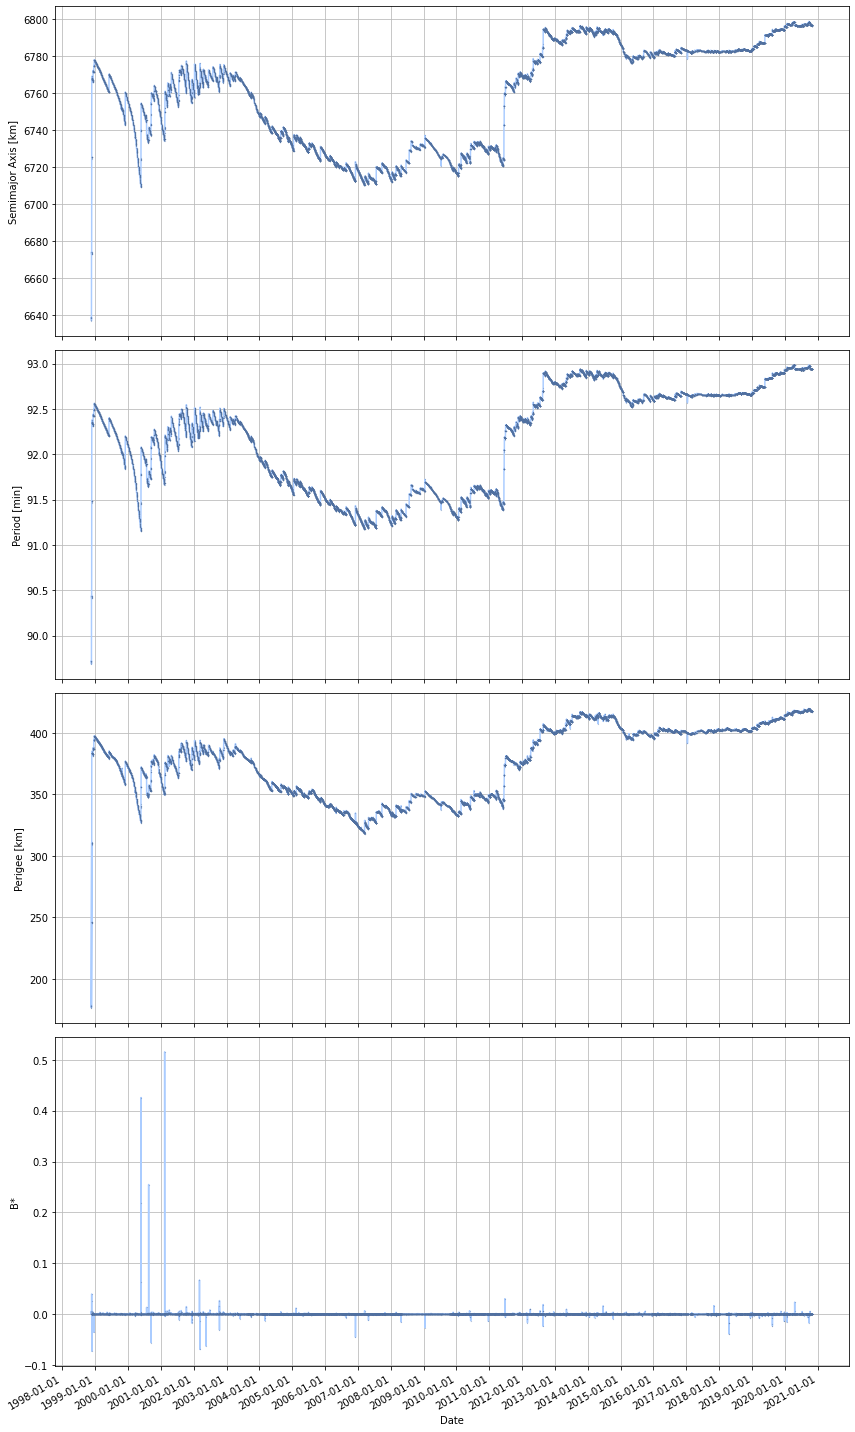

In [17]:
# 時間変化をプロット
fig = plt.figure(figsize=(12, 20))
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(df2['EPOCH2'], df2['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(df2['EPOCH2'], df2['PERIOD'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Period [min]")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(df2['EPOCH2'], df2['PERIGEE'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Perigee [km]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(df2['EPOCH2'], df2['BSTAR'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax4.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax4.set_xlabel("Date")
ax4.set_ylabel("B*")
ax4.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()